In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("IPO_2019to2020.csv")
df.head()

,STOCK,MARKET,YEAR,PUBLICBALLOTINGOSCBED,LISTPRICE,VOLUMEIPODAY,OPENPRICEIPODAY,HIGHESTPRICEIPODAY,CLOSINGPRICEIPODAY
0,TUJUSETIA,MAIN,2021,42.07,0.70,1145707,0.775,0.875,0.74
1,YENHER,MAIN,2021,13.80,0.95,618271,0.995,1.000,0.90
2,CTOS,MAIN,2021,27.57,1.10,3663593,1.500,1.760,1.62
3,AURELIUS,MAIN,2021,20.27,1.36,1870413,1.410,1.850,1.70
4,SWIFT,MAIN,2021,18.85,1.03,1585591,1.080,1.130,0.96


In [3]:
df.shape

(43, 9)

In [4]:
# Create following columns:
# % difference between list price vs opening price on IPO day
# % difference between list price vs highest price on IPO day
# % difference between opening price on IPO day vs closing price on IPO day
# % difference between opening price on IPO day vs highest price on IPO day

In [5]:
df['LISTVSOPENING_PCT'] = df['OPENPRICEIPODAY']/df['LISTPRICE']*100 - 100
df['LISTVSHIGHEST_PCT'] = df['HIGHESTPRICEIPODAY']/df['LISTPRICE']*100 - 100

df['OPENINGVSCLOSING_PCT'] = df['CLOSINGPRICEIPODAY']/df['OPENPRICEIPODAY']*100 - 100
df['OPENINGVSHIGHEST_PCT'] = df['HIGHESTPRICEIPODAY']/df['OPENPRICEIPODAY']*100 - 100

In [6]:
X = df.copy()
del X['YEAR']

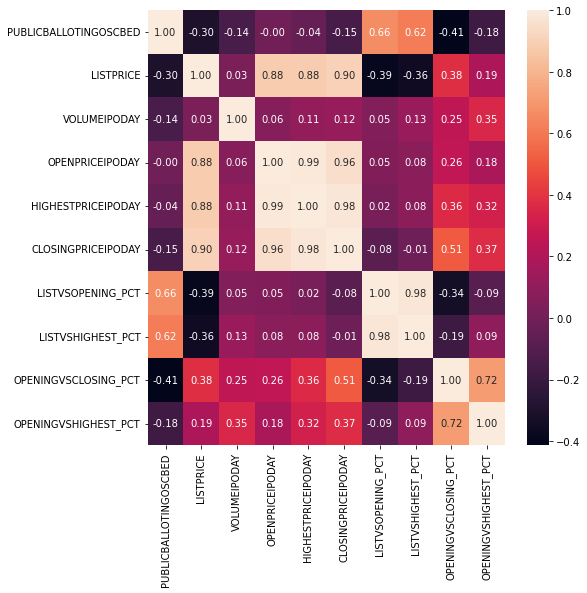

In [7]:
import matplotlib.pyplot as plt
from seaborn import heatmap
fig, ax = plt.subplots(figsize=(8,8))
ax = heatmap(X.corr(), fmt = '.2f',
            annot = True)

0.939663077427465
9.327819137861283


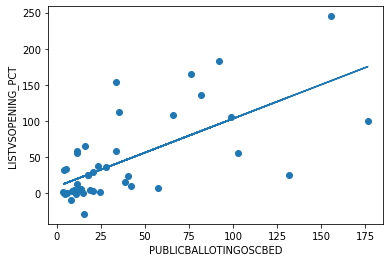

In [15]:
import numpy as np
# plot oversubscription rate vs % difference listing vs opening price
x_label = 'PUBLICBALLOTINGOSCBED'
y_label = 'LISTVSOPENING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)


# ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

m, b = np.polyfit(x, y, 1)

plt.plot(x, m * x + b)

print(m)
print(b)